In [1]:
%load_ext autoreload
%autoreload 2

import json
from pprint import pprint

from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)


#### Load V-COCO annotations

In [2]:
PATH_TO_VCOCO_ANNS = (
    "/Users/poornakumar/project_cs231n/v-coco/data/vcoco/vcoco_train.json"
)
with open(PATH_TO_VCOCO_ANNS, "r") as f:
    vcoco_anns = json.load(f)

#### Load COCO annotations

In [3]:
COCO_DATA_DIR = '../cocoapi'
COCO_DATA_TYPE ='train2017'
ANN_FILE ='{}/annotations/instances_{}.json'.format(COCO_DATA_DIR, COCO_DATA_TYPE)

# initialize COCO api for instance annotations
coco=COCO(ANN_FILE)

loading annotations into memory...
Done (t=14.23s)
creating index...
index created!


In [4]:
print("Example category information from COCO:")
print(f"Category ID: {1}, category information: {coco.cats[1]}")
print("\n**************************************************\n")
print(f"COCO has {len(coco.cats)} categories of objects, namely:\n")
cat_id_name = []
for key in coco.cats.keys():
    cat_id_name.append((key, coco.cats[key]["name"]))
print(cat_id_name)

Example category information from COCO:
Category ID: 1, category information: {'supercategory': 'person', 'id': 1, 'name': 'person'}

**************************************************

COCO has 80 categories of objects, namely:

[(1, 'person'), (2, 'bicycle'), (3, 'car'), (4, 'motorcycle'), (5, 'airplane'), (6, 'bus'), (7, 'train'), (8, 'truck'), (9, 'boat'), (10, 'traffic light'), (11, 'fire hydrant'), (13, 'stop sign'), (14, 'parking meter'), (15, 'bench'), (16, 'bird'), (17, 'cat'), (18, 'dog'), (19, 'horse'), (20, 'sheep'), (21, 'cow'), (22, 'elephant'), (23, 'bear'), (24, 'zebra'), (25, 'giraffe'), (27, 'backpack'), (28, 'umbrella'), (31, 'handbag'), (32, 'tie'), (33, 'suitcase'), (34, 'frisbee'), (35, 'skis'), (36, 'snowboard'), (37, 'sports ball'), (38, 'kite'), (39, 'baseball bat'), (40, 'baseball glove'), (41, 'skateboard'), (42, 'surfboard'), (43, 'tennis racket'), (44, 'bottle'), (46, 'wine glass'), (47, 'cup'), (48, 'fork'), (49, 'knife'), (50, 'spoon'), (51, 'bowl'), (52,

### Parse out V-COCO verbs

In [5]:
verbs_to_anns = {}

def parse_out_pos_neg_ann_ids(ann_dict):
    labels_to_anns = {}
    for master_ann_id, val_tuple in ann_dict.items():
        label = val_tuple[1]
        ann_dict = val_tuple[0]
        if label not in labels_to_anns:
            labels_to_anns[label] = []
        labels_to_anns[label].append([
            v for v in ann_dict.values() if v != 0  # remove "0" annotation ID -- corresponds to NA.
        ])
    return labels_to_anns


ann_id_labels = np.asarray([])
action_names = np.asarray([])
ann_id_reference_list = None
for el in vcoco_anns:
    d = {key: np.asarray(val) for key, val in el.items() if key != "action_name"}
    d["img_to_ann_ids"] = {
        img_id: set(d["ann_id"][d["image_id"] == img_id]) for img_id in set(d["image_id"])
    }
    n_roles = len(d["role_name"])
    assert n_roles * len(d["ann_id"]) == len(d["role_object_id"])
    role_anns = d["role_object_id"].reshape(n_roles, -1)
    d["img_to_ann_ids"] = {
        img_id: {
            # master ann_id (int key) to detailed annotations dictionary (val)
            d["ann_id"][jdx]: (
                {role_name: role_anns[idx][jdx] for idx, role_name in enumerate(d["role_name"])},  # annotations for agent, obj, instr
                d["label"][jdx]  # if the annotation is labeled positive or negative
            )
            for jdx in np.nonzero(d["image_id"] == img_id)[0]  # indices of annotations corresponding to the image
        } for img_id in set(d["image_id"])
    }
    d["img_to_label_to_ann_ids"] = {
        img_id: parse_out_pos_neg_ann_ids(d["img_to_ann_ids"][img_id])
        for img_id in d["image_id"]
    }
    d["master_ann_to_img_ids"] = {
        d["ann_id"][jdx]: d["image_id"][jdx] for jdx in range(len(d["ann_id"]))
    }
    master_ann_to_img_ids = d["master_ann_to_img_ids"]
    verbs_to_anns[el["action_name"]] = d
    ############################################################################################################################
    # Prep annotation ID to verb data
    action_names = np.append(action_names, el["action_name"])
    if ann_id_reference_list is None:
        ann_id_reference_list = d["ann_id"]
        ann_id_labels = d["label"].reshape(1, -1)
    else:
        assert all(ann_id_reference_list == d["ann_id"])  # Make sure that all the verbs have annotation IDs in the same order
        ann_id_labels = np.append(ann_id_labels, d["label"].reshape(1, -1), axis=0)
        

anns_to_verbs = {}
ann_id_labels_t = ann_id_labels.T
for idx, ann_row in enumerate(ann_id_labels_t):
    verb_ids = np.where(ann_row == 1)
    anns_to_verbs[ann_id_reference_list[idx]] = action_names[verb_ids]

print("Verbs included: ", list(verbs_to_anns.keys()))
print()
print("Dict attributes for each verb:", verbs_to_anns["hold"].keys())

Verbs included:  ['hold', 'stand', 'sit', 'ride', 'walk', 'look', 'hit', 'eat', 'jump', 'lay', 'talk_on_phone', 'carry', 'throw', 'catch', 'cut', 'run', 'work_on_computer', 'ski', 'surf', 'skateboard', 'smile', 'drink', 'kick', 'point', 'read', 'snowboard']

Dict attributes for each verb: dict_keys(['image_id', 'ann_id', 'role_object_id', 'label', 'role_name', 'include', 'img_to_ann_ids', 'img_to_label_to_ann_ids', 'master_ann_to_img_ids'])


### Role names for each verb

In [6]:
for verb, d in verbs_to_anns.items():
    print(verb, tuple(d["role_name"]))

hold ('agent', 'obj')
stand ('agent',)
sit ('agent', 'instr')
ride ('agent', 'instr')
walk ('agent',)
look ('agent', 'obj')
hit ('agent', 'instr', 'obj')
eat ('agent', 'obj', 'instr')
jump ('agent', 'instr')
lay ('agent', 'instr')
talk_on_phone ('agent', 'instr')
carry ('agent', 'obj')
throw ('agent', 'obj')
catch ('agent', 'obj')
cut ('agent', 'instr', 'obj')
run ('agent',)
work_on_computer ('agent', 'instr')
ski ('agent', 'instr')
surf ('agent', 'instr')
skateboard ('agent', 'instr')
smile ('agent',)
drink ('agent', 'instr')
kick ('agent', 'obj')
point ('agent', 'instr')
read ('agent', 'obj')
snowboard ('agent', 'instr')


### Labels per master annotation

Each master annotation in V-COCO can belong to 0 or more verb categories.

In [7]:
n_cats_per_ann = ann_id_labels.sum(axis=0)
min(n_cats_per_ann), max(n_cats_per_ann), np.mean(n_cats_per_ann), np.median(n_cats_per_ann)

(0, 7, 2.8802136317395726, 3.0)

How many annotations have _zero_ associated verbs? Very few. These seem to correspond to images of _parts_ of people with too little context to say anything about the person's actions.

In [8]:
def show_annotation(ann_id):
    img_id = master_ann_to_img_ids[ann_id]
    img = coco.loadImgs([img_id])[0]  # Returned value is a list of dicts (one dict per image ID supplied) => extract the first element (dict)
    # load and display image
    I = io.imread('%s/images/%s/%s'%(COCO_DATA_DIR, COCO_DATA_TYPE, img['file_name']))
    plt.figure()
    plt.axis('off')
    plt.imshow(I)
    plt.axis('off')
    anns = coco.loadAnns([ann_id])
    coco.showAnns(anns, draw_bbox=True)

36 anns have no associated verbs; 3932 annotations total.


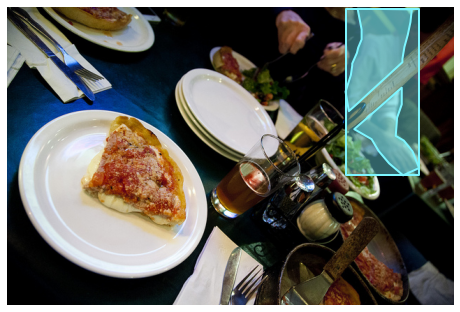

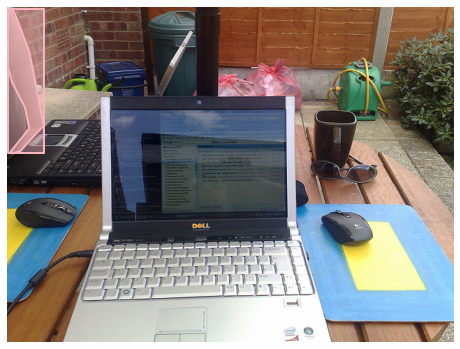

In [9]:
print(f"{(n_cats_per_ann == 0).sum()} anns have no associated verbs; {n_cats_per_ann.shape[0]} annotations total.")

ann_id_index = np.where(n_cats_per_ann == 0)[0][0]
ann_id = ann_id_reference_list[ann_id_index]
show_annotation(ann_id)

ann_id_index = np.where(n_cats_per_ann == 0)[0][1]
ann_id = ann_id_reference_list[ann_id_index]
show_annotation(ann_id)

In [27]:
np.random.seed(123)
rand_keys = np.random.choice(list(anns_to_verbs.keys()), 20)
for key in rand_keys:
    print(
        f"Annotation ID {key} corresponds to verbs {anns_to_verbs[key]}"
    )

Annotation ID 1739362 corresponds to verbs ['stand' 'look' 'run']
Annotation ID 1711406 corresponds to verbs ['hold' 'stand' 'hit']
Annotation ID 1714770 corresponds to verbs ['stand' 'look' 'snowboard']
Annotation ID 453897 corresponds to verbs ['hold' 'stand' 'ski']
Annotation ID 444570 corresponds to verbs ['lay']
Annotation ID 474578 corresponds to verbs ['hold' 'look' 'talk_on_phone']
Annotation ID 1263885 corresponds to verbs ['walk']
Annotation ID 1760659 corresponds to verbs ['hold' 'sit' 'eat']
Annotation ID 495436 corresponds to verbs ['stand' 'look' 'run' 'kick']
Annotation ID 445723 corresponds to verbs ['stand' 'look' 'jump' 'catch']
Annotation ID 466142 corresponds to verbs ['hold' 'stand' 'look']
Annotation ID 1309284 corresponds to verbs ['stand' 'skateboard']
Annotation ID 474231 corresponds to verbs ['hold' 'stand' 'talk_on_phone']
Annotation ID 190243 corresponds to verbs ['hold' 'stand' 'carry']
Annotation ID 496131 corresponds to verbs ['sit' 'look' 'work_on_comput

Let's pick one of the random annotation IDs above and print images/annotations corresponding to its different verbs.

hold ['agent' 'obj'] [(437303, 'person'), (322681, 'cell phone')]
sit ['agent' 'instr'] [(437303, 'person')]
ride ['agent' 'instr'] [(437303, 'person'), (1191026, 'car')]
look ['agent' 'obj'] [(437303, 'person'), (322681, 'cell phone')]


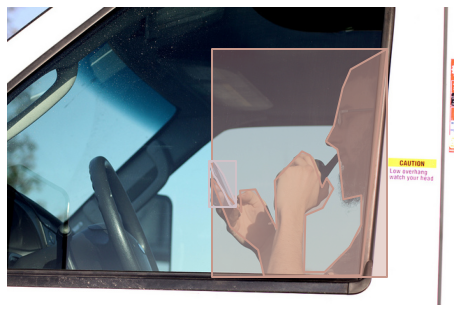

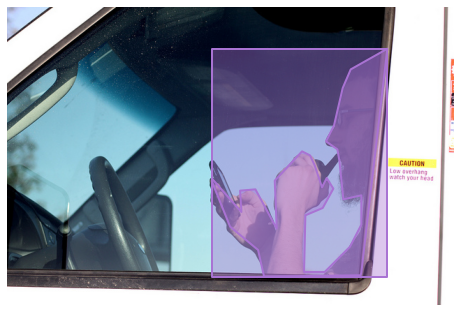

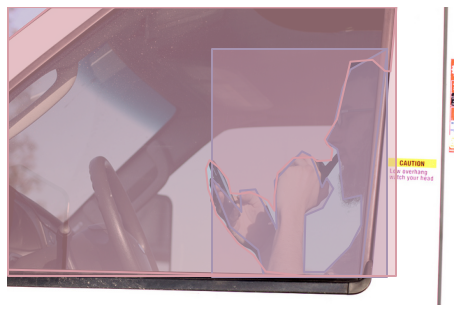

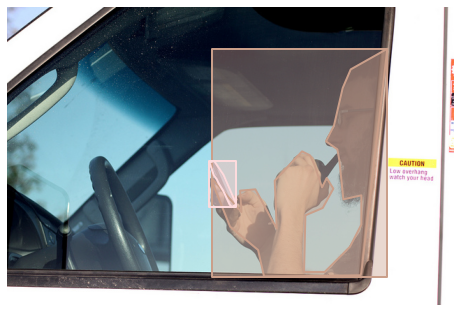

In [28]:
ann_id = 437303
for verb_idx, verb in enumerate(anns_to_verbs[ann_id]):
    anns_dict_for_verb = verbs_to_anns[verb]
    img_id = anns_dict_for_verb["master_ann_to_img_ids"][ann_id]
    img = coco.loadImgs([img_id])[0]  # Returned value is a list of dicts (one dict per image ID supplied) => extract the first element (dict)
    # load and display image
    I = io.imread('%s/images/%s/%s'%(COCO_DATA_DIR, COCO_DATA_TYPE, img['file_name']))
    plt.figure(verb_idx)
    plt.axis('off')
    plt.imshow(I)
    plt.axis('off')
    anns_to_load = list(anns_dict_for_verb["img_to_ann_ids"][img_id][ann_id][0].values())
    anns = coco.loadAnns([a for a in anns_to_load if a != 0])
    print(verb, anns_dict_for_verb["role_name"], [(ann["id"], coco.cats[ann["category_id"]]["name"]) for ann in anns])
    coco.showAnns(anns, draw_bbox=True)

#### Annotations per image

In [12]:
verb = "snowboard"

pos_neg_found = False

for img, label_to_ann_ids in verbs_to_anns[verb]["img_to_label_to_ann_ids"].items():
    if len(label_to_ann_ids) > 1 and not pos_neg_found:
        print(f"Image ID containing both positive and negative labels for {verb}:", img)
        pos_neg_found = True    

Image ID containing both positive and negative labels for snowboard: 7357


In [13]:
print("Image with several annotations:\n")
pprint(verbs_to_anns["snowboard"]["img_to_ann_ids"][188478])
print()
pprint(verbs_to_anns["snowboard"]["img_to_label_to_ann_ids"][188478])
print("\n**************************************************\n")
print("Image with one annotation:\n")
pprint(verbs_to_anns["snowboard"]["img_to_ann_ids"][2583])
print()
pprint(verbs_to_anns["snowboard"]["img_to_label_to_ann_ids"][2583])
print("\n**************************************************\n")
print("Image with both positive and negative labels:\n")
pprint(verbs_to_anns["snowboard"]["img_to_ann_ids"][7357])
print()
pprint(verbs_to_anns["snowboard"]["img_to_label_to_ann_ids"][7357])

Image with several annotations:

{1232405: ({'agent': 1232405, 'instr': 0}, 0),
 1233548: ({'agent': 1233548, 'instr': 0}, 0),
 1293037: ({'agent': 1293037, 'instr': 0}, 0),
 1302215: ({'agent': 1302215, 'instr': 0}, 0),
 1314968: ({'agent': 1314968, 'instr': 0}, 0)}

{0: [[1232405], [1233548], [1293037], [1302215], [1314968]]}

**************************************************

Image with one annotation:

{462340: ({'agent': 462340, 'instr': 617525}, 1)}

{1: [[462340, 617525]]}

**************************************************

Image with both positive and negative labels:

{426751: ({'agent': 426751, 'instr': 0}, 0),
 471895: ({'agent': 471895, 'instr': 2213151}, 1)}

{0: [[426751]], 1: [[471895, 2213151]]}


In [14]:
verbs_to_anns["hold"]["img_to_ann_ids"].keys() == verbs_to_anns["snowboard"]["img_to_ann_ids"].keys()

True

#### Display examples of different verbs

In [15]:
np.random.seed(3003)
samples = {}
for verb, d in verbs_to_anns.items():
    pos_label_idx = np.random.choice(np.nonzero(d["label"] == 1)[0], 5)
    neg_label_idx = np.random.choice(np.nonzero(d["label"] == 0)[0], 5)
    # Each positive image, will have one or more master annotations. 
    # At least one of these master annotations is positive.
    pos_img_ids = d["image_id"][pos_label_idx]
    # Each negative image, will have one or more master annotations. 
    # At least one of these master annotations is negative.
    neg_img_ids = d["image_id"][neg_label_idx]
    # Dict of ALL annotations in positive and negative
    img_to_label_to_ann_ids = {
        img_id: d["img_to_label_to_ann_ids"][img_id]
        for img_id in np.concatenate((pos_img_ids, neg_img_ids))
    }
    samples[verb] = {
        "role_name": d["role_name"],
        "pos_img_ids": pos_img_ids,
        "neg_img_ids": neg_img_ids,
        "img_to_label_to_ann_ids": img_to_label_to_ann_ids
    }

Let's start with `hold`.

In [16]:
pprint(samples["hold"]["img_to_label_to_ann_ids"])
pprint(samples["hold"]["pos_img_ids"])
pprint(samples["hold"]["neg_img_ids"])

{45437: {0: [[210331]], 1: [[210043, 322779]]},
 128706: {0: [[472056]]},
 375504: {1: [[1210891, 650716]]},
 445990: {1: [[481551, 618543], [508551], [1241947, 607611]]},
 456462: {1: [[479326]]},
 484646: {0: [[427595]], 1: [[497591, 647868]]},
 495100: {0: [[478351], [519145]]},
 544850: {1: [[193467, 1108274], [196482, 1112622]]},
 547764: {1: [[456561], [485235]]},
 554886: {0: [[1209499]], 1: [[422587, 634865]]}}
array([445990, 544850, 375504, 456462, 547764])
array([ 45437, 128706, 484646, 495100, 554886])


{1: [[481551, 618543], [508551], [1241947, 607611]]}
[(481551, 'person'), (618543, 'snowboard'), (508551, 'person'), (1241947, 'person'), (607611, 'skis')]


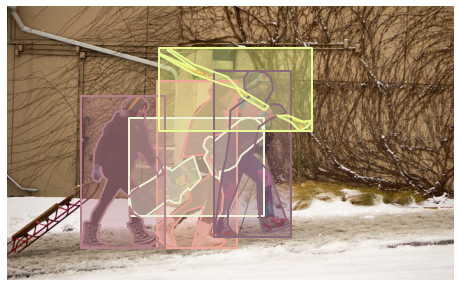

In [17]:
verb = "hold"
label = 1
img_id = samples[verb]["pos_img_ids"][0]
img = coco.loadImgs([img_id])[0]  # Returned value is a list of dicts (one dict per image ID supplied) => extract the first element (dict)
# load and display image
I = io.imread('%s/images/%s/%s'%(COCO_DATA_DIR, COCO_DATA_TYPE, img['file_name']))
plt.axis('off')
plt.imshow(I)
plt.axis('off')
print(samples[verb]["img_to_label_to_ann_ids"][img_id])
anns_to_load = np.concatenate(samples[verb]["img_to_label_to_ann_ids"][img_id][label])
anns = coco.loadAnns(anns_to_load)
print([(ann["id"], coco.cats[ann["category_id"]]["name"]) for ann in anns])
coco.showAnns(anns, draw_bbox=True)

{1: [[193467, 1108274], [196482, 1112622]]}
[(193467, 'person'), (1108274, 'remote'), (196482, 'person'), (1112622, 'remote')]


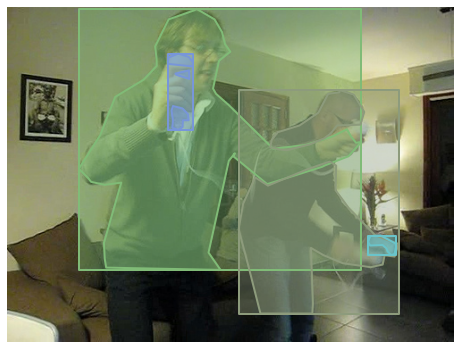

In [18]:
verb = "hold"
label = 1
img_id = samples[verb]["pos_img_ids"][1]
img = coco.loadImgs([img_id])[0]  # Returned value is a list of dicts (one dict per image ID supplied) => extract the first element (dict)
# load and display image
I = io.imread('%s/images/%s/%s'%(COCO_DATA_DIR, COCO_DATA_TYPE, img['file_name']))
plt.axis('off')
plt.imshow(I)
plt.axis('off')
print(samples[verb]["img_to_label_to_ann_ids"][img_id])
anns_to_load = np.concatenate(samples[verb]["img_to_label_to_ann_ids"][img_id][label])
anns = coco.loadAnns(anns_to_load)
print([(ann["id"], coco.cats[ann["category_id"]]["name"]) for ann in anns])
coco.showAnns(anns, draw_bbox=True)

{1: [[1210891, 650716]]}
[(1210891, 'person'), (650716, 'surfboard')]


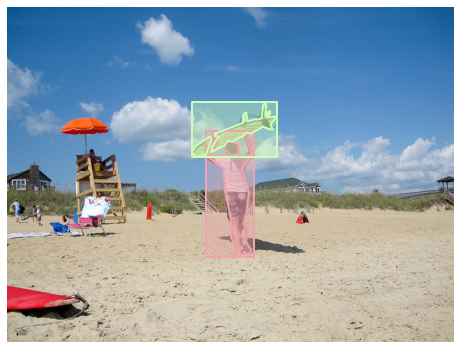

In [19]:
verb = "hold"
label = 1
img_id = samples[verb]["pos_img_ids"][2]
img = coco.loadImgs([img_id])[0]  # Returned value is a list of dicts (one dict per image ID supplied) => extract the first element (dict)
# load and display image
I = io.imread('%s/images/%s/%s'%(COCO_DATA_DIR, COCO_DATA_TYPE, img['file_name']))
plt.axis('off')
plt.imshow(I)
plt.axis('off')
print(samples[verb]["img_to_label_to_ann_ids"][img_id])
anns_to_load = np.concatenate(samples[verb]["img_to_label_to_ann_ids"][img_id][label])
anns = coco.loadAnns(anns_to_load)
print([(ann["id"], coco.cats[ann["category_id"]]["name"]) for ann in anns])
coco.showAnns(anns, draw_bbox=True)

Here's an image with a negative example of "hold":

[(210331, 'person')]


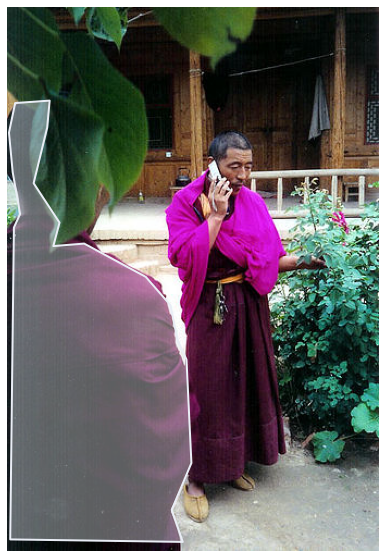

In [20]:
verb = "hold"
label = 0
img_id = samples[verb]["neg_img_ids"][0]
img = coco.loadImgs([img_id])[0]  # Returned value is a list of dicts (one dict per image ID supplied) => extract the first element (dict)
# load and display image
I = io.imread('%s/images/%s/%s'%(COCO_DATA_DIR, COCO_DATA_TYPE, img['file_name']))
plt.axis('off')
plt.imshow(I)
plt.axis('off')
#print(samples[verb]["img_to_label_to_ann_ids"][img_id])
anns_to_load = np.concatenate(samples[verb]["img_to_label_to_ann_ids"][img_id][label])
anns = coco.loadAnns(anns_to_load)
print([(ann["id"], coco.cats[ann["category_id"]]["name"]) for ann in anns ])
coco.showAnns(anns, draw_bbox=False)

The monk image also has a positive example for "hold".

[(210043, 'person'), (322779, 'cell phone')]


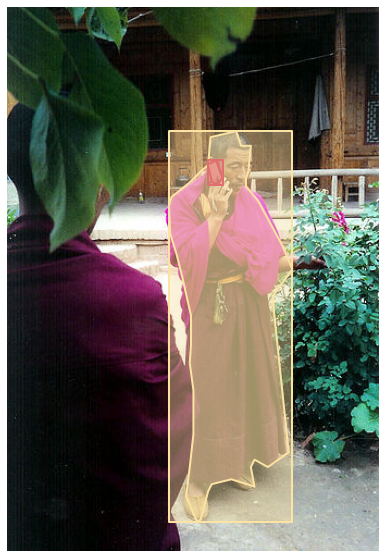

In [21]:
verb = "hold"
label = 1
img_id = samples[verb]["neg_img_ids"][0]
caption_label = {1: "positive", 2: "negative"}
img = coco.loadImgs([img_id])[0]  # Returned value is a list of dicts (one dict per image ID supplied) => extract the first element (dict)
# load and display image
I = io.imread('%s/images/%s/%s'%(COCO_DATA_DIR, COCO_DATA_TYPE, img['file_name']))
plt.axis('off')
plt.imshow(I)
plt.axis('off')
#print(samples[verb]["img_to_label_to_ann_ids"][img_id])
anns_to_load = np.concatenate(samples[verb]["img_to_label_to_ann_ids"][img_id][label])
anns = coco.loadAnns(anns_to_load)
print([(ann["id"], coco.cats[ann["category_id"]]["name"]) for ann in anns ])
coco.showAnns(anns, draw_bbox=True)